In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Importing the required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV,train_test_split
from collections import Counter
%matplotlib inline

In [4]:
# Loading the dataset
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/heart_failure_clinical_records_dataset.csv')
df


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00,1.1,143,1,1,270,0
295,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0,271,0
296,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0,278,0
297,45.0,0,2413,0,38,0,140000.00,1.4,140,1,1,280,0


In [5]:
df.isna().sum()

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

In [6]:
df.isnull().sum() 

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

In [7]:
labels=["Healthy","Heart Disease"]

healthy_or_not = df['DEATH_EVENT'].value_counts().tolist()
values = [healthy_or_not[0], healthy_or_not[1]]

fig = px.pie(values=df['DEATH_EVENT'].value_counts(), names=labels , width=700, height=400, color_discrete_sequence=["blue","red"]
             ,title="Healthy vs Heart Disease")
fig.show()


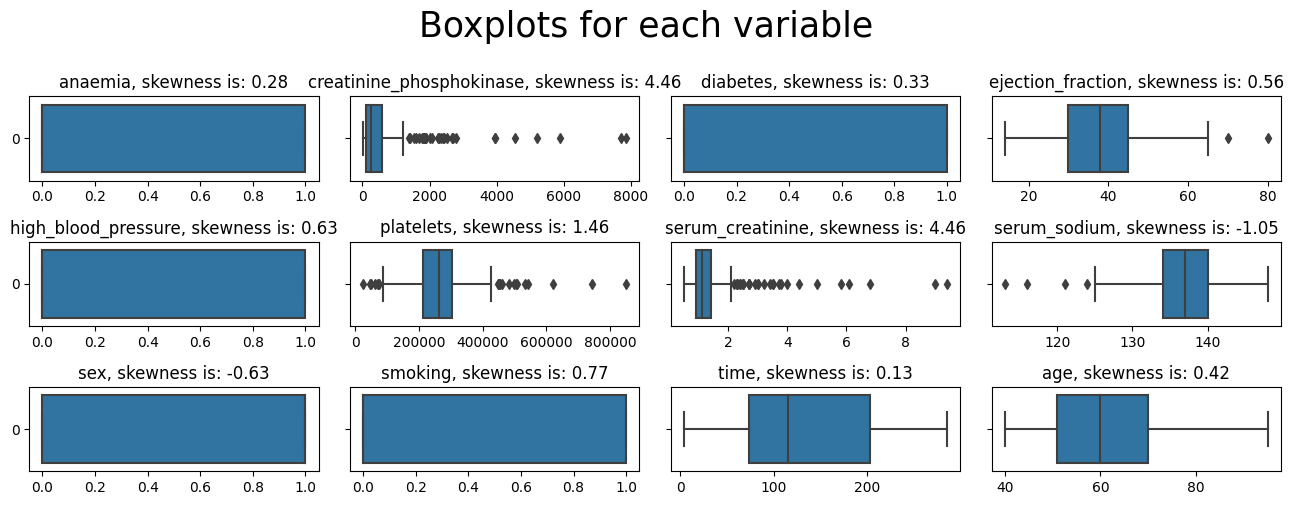

In [10]:
numerical_columns = list(df.loc[:,list(df.columns)[ : -1]])

def boxplots_custom(dataset, columns_list, rows, cols, suptitle):
    fig, axs = plt.subplots(rows, cols, sharey=True, figsize=(13,5))
    fig.suptitle(suptitle,y=1, size=25)
    axs = axs.flatten()
    for i, data in enumerate(columns_list):
        sns.boxplot(data=dataset[data], orient='h', ax=axs[i-1])
        axs[i-1].set_title(data + ', skewness is: '+str(round(dataset[data].skew(axis = 0, skipna = True),2)))
        
boxplots_custom(dataset=df, columns_list=numerical_columns, rows=3, cols=4, suptitle='Boxplots for each variable')
plt.tight_layout()

In [11]:
def IQR_method (df,n,features):
    """
    Takes a dataframe and returns an index list corresponding to the observations 
    containing more than n outliers according to the Tukey IQR method.
    """
    outlier_list = []
    
    for column in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[column], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[column],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        # outlier step
        outlier_step = 1.5 * IQR
        # Determining a list of indices of outliers
        outlier_list_column = df[(df[column] < Q1 - outlier_step) | (df[column] > Q3 + outlier_step )].index
        # appending the list of outliers 
        outlier_list.extend(outlier_list_column)
        
    # selecting observations containing more than x outliers
    outlier_list = Counter(outlier_list)        
    multiple_outliers = list( k for k, v in outlier_list.items() if v > n )
    
    # Calculate the number of records below and above lower and above bound value respectively
    out1 = df[df[column] < Q1 - outlier_step]
    out2 = df[df[column] > Q3 + outlier_step]
    
    print('Total number of deleted outliers is:', out1.shape[0]+out2.shape[0])
    
    return multiple_outliers

In [12]:
# detecting outliers
Outliers_IQR = IQR_method(df,1,numerical_columns)

# dropping outliers
df = df.drop(Outliers_IQR, axis = 0).reset_index(drop=True)

Total number of deleted outliers is: 0


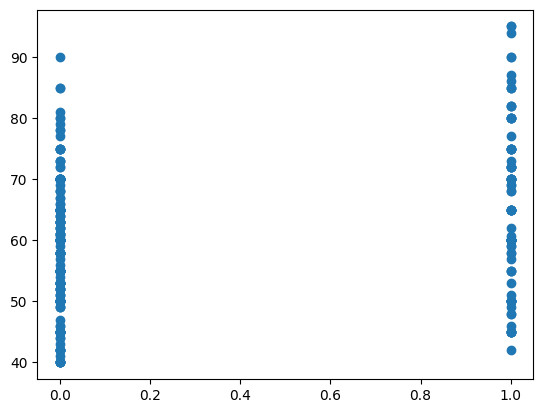

In [13]:
plt.scatter(df['DEATH_EVENT'],df['age'])
plt.show()

c = df.corr()
c['DEATH_EVENT'].sort_values(ascending = False)
x = df.drop('DEATH_EVENT',axis = 1)
y = df['DEATH_EVENT'].copy()
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.25,random_state=51)

In [14]:
from sklearn.preprocessing import StandardScaler

# Creating function for scaling
def Standard_Scaler (df, col_names):
    features = df[col_names]
    scaler = StandardScaler().fit(features.values)
    features = scaler.transform(features.values)
    df[col_names] = features
    
    return df

In [15]:
col_names = numerical_columns
x_train = Standard_Scaler (x_train, col_names)
x_test = Standard_Scaler (x_test, col_names)

In [16]:
# Applying Logistic Regression
lr = LogisticRegression()
lr.fit(x_train, y_train)
lr_pred = lr.predict(x_test)
lr_acc = accuracy_score(y_test, lr_pred)
print("Logistic Regression Accuracy:", lr_acc)
print(classification_report(y_test, lr_pred))

Logistic Regression Accuracy: 0.8904109589041096
              precision    recall  f1-score   support

           0       0.92      0.92      0.92        51
           1       0.82      0.82      0.82        22

    accuracy                           0.89        73
   macro avg       0.87      0.87      0.87        73
weighted avg       0.89      0.89      0.89        73



In [17]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

predict_x=lr.predict(x_test) 
y_pred=np.argmax(predict_x,axis=0)
lr_cm=confusion_matrix(y_test,predict_x)
lr_cm

array([[47,  4],
       [ 4, 18]])

In [18]:
# Applying Random Forest
rf = RandomForestClassifier(max_features=8, random_state = 42,n_estimators=8)
rf.fit(x_train, y_train)
rf_pred = rf.predict(x_test)
rf_acc = accuracy_score(y_test, rf_pred)
print("Random Forest Accuracy:", rf_acc)
print(classification_report(y_test, rf_pred))

Random Forest Accuracy: 0.863013698630137
              precision    recall  f1-score   support

           0       0.87      0.94      0.91        51
           1       0.83      0.68      0.75        22

    accuracy                           0.86        73
   macro avg       0.85      0.81      0.83        73
weighted avg       0.86      0.86      0.86        73



In [19]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

predict_x=rf.predict(x_test) 
y_pred=np.argmax(predict_x,axis=0)
rf_cm=confusion_matrix(y_test,predict_x)
rf_cm

array([[48,  3],
       [ 7, 15]])

In [61]:
# Applying K-Nearest Neighbors
from sklearn.model_selection import cross_val_score
knn = KNeighborsClassifier(n_neighbors=6)
scores = cross_val_score(knn,x,y,cv=10,scoring='accuracy')
knn.fit(x_train, y_train)
knn_pred = knn.predict(x_test)
knn_acc = accuracy_score(y_test, knn_pred)
print("KNN Accuracy:", knn_acc)
# print(scores)
# print(scores.mean())
print(classification_report(y_test, knn_pred))

KNN Accuracy: 0.7123287671232876
              precision    recall  f1-score   support

           0       0.71      0.98      0.83        51
           1       0.67      0.09      0.16        22

    accuracy                           0.71        73
   macro avg       0.69      0.54      0.49        73
weighted avg       0.70      0.71      0.63        73



In [21]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

predict_x=knn.predict(x_test) 
y_pred=np.argmax(predict_x,axis=0)
svm_knn=confusion_matrix(y_test,predict_x)
svm_knn

array([[45,  6],
       [11, 11]])

In [22]:
# Applying Support Vector Machine
param_grid = {'C': [0.1, 1, 10], 'gamma': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
svc = SVC(kernel='linear')
grid_search = GridSearchCV(svc, param_grid, cv=5)
grid_search.fit(x_train, y_train)
# Print best hyperparameters and score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

# Evaluate model on test set
y_pred = grid_search.predict(x_test)
print("Test set score: ", grid_search.score(x_test, y_test))

svm = SVC(kernel='linear', C=1, gamma=0.1)
svm.fit(x_train, y_train)
svm_pred = svm.predict(x_test)
svm_acc = accuracy_score(y_test, svm_pred)
print("SVM Accuracy:", svm_acc)
print(classification_report(y_test, svm_pred))

Best hyperparameters:  {'C': 10, 'gamma': 0.1, 'kernel': 'linear'}
Best score:  0.837737843551797
Test set score:  0.863013698630137
SVM Accuracy: 0.863013698630137
              precision    recall  f1-score   support

           0       0.89      0.92      0.90        51
           1       0.80      0.73      0.76        22

    accuracy                           0.86        73
   macro avg       0.84      0.82      0.83        73
weighted avg       0.86      0.86      0.86        73



In [ ]:
SVC().fit(x_train, y_train)

In [24]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

predict_x=svm.predict(x_test) 
y_pred=np.argmax(predict_x,axis=0)
svm_cm=confusion_matrix(y_test,predict_x)
svm_cm
# mat = confusion_matrix(y_test,y_pred)
# plot_confusion_matrix(conf_mat=cm, show_normed=True, figsize=(7,7))

array([[47,  4],
       [ 6, 16]])

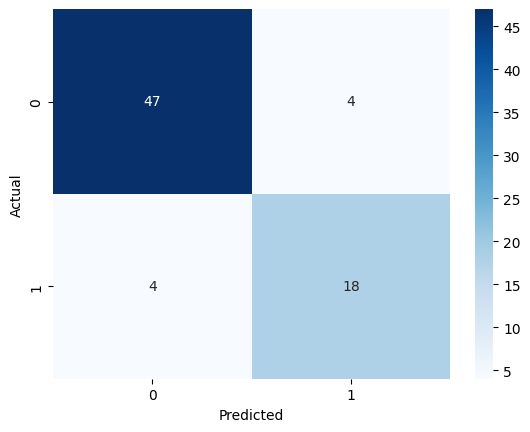

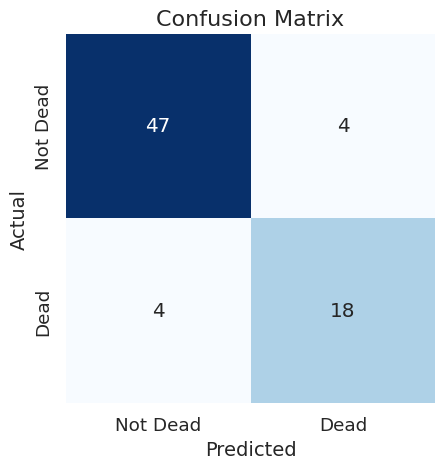

In [25]:
from sklearn.metrics import confusion_matrix

mat = confusion_matrix(y_test,lr_pred)

sns.heatmap(mat, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

sns.set(font_scale=1.2)
sns.heatmap(mat, annot=True, fmt='d', cmap='Blues', cbar=False, square=True,
            xticklabels=['Not Dead', 'Dead'], yticklabels=['Not Dead', 'Dead'])
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

plt.show()